In [1]:
import os
import json
import skimage
import shutil
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt

### Set config

In [2]:
config_filename = 'demo_config.json'
debug = True

In [3]:
cresi_dir = '/opt/cresi'
%cd {cresi_dir}

/opt/cresi


In [4]:
src_dir = os.path.join(cresi_dir, 'cresi')
results_dir = os.path.join(cresi_dir, 'results')
data_dir  = os.path.join(cresi_dir, 'data')

config_dir = os.path.join(cresi_dir, src_dir, 'configs')
weight_dir = os.path.join(cresi_dir, src_dir, config_dir, 'weights')

raw_data_dir = os.path.join(cresi_dir, data_dir, 'raw_data')
eight_bit_dir = os.path.join(cresi_dir, data_dir, '8bit_data')
sliced_dir = os.path.join(cresi_dir, data_dir, 'sliced_data')

mask_pred_dir = os.path.join(results_dir, 'folds')
mask_stitched_dir = os.path.join(results_dir, 'stitched/mask_norm')

In [5]:
config_path = os.path.join(config_dir, config_filename)

# update directories
with open(config_path, 'r+') as f:
    data = json.load(f)
    data['path_src'] = src_dir
    data['path_data_root'] = data_dir
    data['path_results_root'] = results_dir
    data['save_weights_dir'] = weight_dir
    
    data['eight_bit_dir'] = eight_bit_dir
    data['sliced_dir'] = sliced_dir

In [6]:
# write new values
os.remove(config_path)
with open(config_path, 'w') as f:
    json.dump(data, f, indent=4)

### Clear previous results

In [7]:
for f in os.listdir(eight_bit_dir):
    os.remove(os.path.join(eight_bit_dir, f))
    
for f in os.listdir(sliced_dir):
    os.remove(os.path.join(sliced_dir, f))
    
for f in os.listdir(results_dir):
    try:
        os.remove(os.path.join(results_dir, f))
    except:
        shutil.rmtree(os.path.join(results_dir, f))

### Convert 16bit MS to 8bit, 3 band

In [8]:
#import rasterio 
"""
for im_name in os.listdir(test_im_clip_dir):
    break
    ds = rasterio.open(os.path.join(test_im_clip_dir, im_name))

    n_ds = rasterio.open(
        os.path.join(test_final_dir, im_name),
        'w',
        driver='GTiff',
        height=ds.shape[0],
        width=ds.shape[1],
        count=3, # 3 bands
        dtype='uint8', # 8 bit
        crs=ds.crs, # copy from orig
        transform=ds.transform # lonlat bounds, copy from orig
    )
    
    # 3 band orig
    if len(ds.dtypes) == 3:
        n_ds.write_band(1, ds.read(1).astype('uint8'))
        n_ds.write_band(2, ds.read(2).astype('uint8'))
        n_ds.write_band(3, ds.read(3).astype('uint8'))
    elif len(ds.dtypes) == 8:
        n_ds.write_band(1, ds.read(5).astype('uint8'))
        n_ds.write_band(2, ds.read(3).astype('uint8'))
        n_ds.write_band(3, ds.read(2).astype('uint8'))
    else:
        print ('Unknown source type.')
    
    n_ds.close()
"""
 

"\nfor im_name in os.listdir(test_im_clip_dir):\n    break\n    ds = rasterio.open(os.path.join(test_im_clip_dir, im_name))\n\n    n_ds = rasterio.open(\n        os.path.join(test_final_dir, im_name),\n        'w',\n        driver='GTiff',\n        height=ds.shape[0],\n        width=ds.shape[1],\n        count=3, # 3 bands\n        dtype='uint8', # 8 bit\n        crs=ds.crs, # copy from orig\n        transform=ds.transform # lonlat bounds, copy from orig\n    )\n    \n    # 3 band orig\n    if len(ds.dtypes) == 3:\n        n_ds.write_band(1, ds.read(1).astype('uint8'))\n        n_ds.write_band(2, ds.read(2).astype('uint8'))\n        n_ds.write_band(3, ds.read(3).astype('uint8'))\n    elif len(ds.dtypes) == 8:\n        n_ds.write_band(1, ds.read(5).astype('uint8'))\n        n_ds.write_band(2, ds.read(3).astype('uint8'))\n        n_ds.write_band(3, ds.read(2).astype('uint8'))\n    else:\n        print ('Unknown source type.')\n    \n    n_ds.close()\n"

In [9]:
# this works much better, but we can't use gdal 
from cresi import create_8bit_images

# Convert 16-bit multispectral test data to 8-bit RGB
create_8bit_images.dir_to_8bit(raw_data_dir, eight_bit_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[]) # specify [5,3,2] if MS channels. Here we are using RGB itself

im_files: ['000-001-RGB.tif']
Input file size is 5057, 5057
0...10...20...30...40...50...60...70...80...90...100 - done.


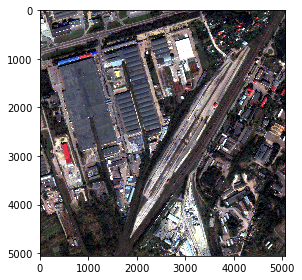

In [10]:
# display our image
im_name = [z for z in os.listdir(eight_bit_dir) if z.endswith('.tif')][0]
im_path = os.path.join(eight_bit_dir, im_name)
im = skimage.io.imread(im_path)

skimage.io.imshow(im) 
skimage.io.show()

### Slice image into processable chunks
slice_x, slice_y defined in config

In [11]:
%run -i cresi/01_slice.py { config_path }

Executing tile_im.py..
slice command: python /opt/cresi/cresi/data_prep/tile_im.py /opt/cresi/cresi/configs/demo_config.json
Output path for sliced images: /opt/cresi/data/sliced_data
processing starting
Slicing /opt/cresi/data/8bit_data
im_path /opt/cresi/data/8bit_data/000-001-RGB.tif
im.shape: (5057, 5057, 3)
n pixels: 25573249
nbands  3
  len df; 16
  Time to slice arrays: 4.38936972618103 seconds
  Total pixels in test image(s): 25573249
df saved to file: /opt/cresi/results/tile_df.csv


### Run Inference

In [12]:
%run -i cresi/02_eval.py { config_path }

save_dir: /opt/cresi/results/folds
paths: {'masks': '', 'images': '/opt/cresi/data/sliced_data'}
fn_mapping: {'masks': <function <lambda> at 0x7f352e6c9c10>}
image_suffix: 
num_workers: 0
fold: 0
run eval.Evaluator.predict()...
prefix: fold0_
Creating datasets within pytorch_utils/eval.py()...
val_indexes:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
len val_dl: 16
self.num_workers 4
Running eval.read_model()...
load model with cpu
  model sucessfully loaded


  0%|                                                                                                                           | 0/16 [00:00<?, ?it/s]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


  6%|███████▏                                                                                                           | 1/16 [00:16<04:08, 16.54s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 12%|██████████████▍                                                                                                    | 2/16 [00:33<03:51, 16.55s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 19%|█████████████████████▌                                                                                             | 3/16 [00:50<03:37, 16.72s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 25%|████████████████████████████▊                                                                                      | 4/16 [01:06<03:20, 16.70s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 31%|███████████████████████████████████▉                                                                               | 5/16 [01:25<03:10, 17.30s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 38%|███████████████████████████████████████████▏                                                                       | 6/16 [01:42<02:54, 17.45s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 44%|██████████████████████████████████████████████████▎                                                                | 7/16 [01:59<02:35, 17.27s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 50%|█████████████████████████████████████████████████████████▌                                                         | 8/16 [02:16<02:17, 17.22s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 56%|████████████████████████████████████████████████████████████████▋                                                  | 9/16 [02:33<01:59, 17.05s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 62%|███████████████████████████████████████████████████████████████████████▎                                          | 10/16 [02:50<01:41, 16.95s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 11/16 [03:06<01:23, 16.80s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 12/16 [03:23<01:07, 16.76s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 13/16 [03:39<00:50, 16.68s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 14/16 [03:56<00:33, 16.69s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 15/16 [04:13<00:16, 16.82s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:30<00:00, 16.89s/it]


AttributeError: 'FullImageEvaluator' object has no attribute 'post_predict_action'

### Evaluate results

The 02_eval.py script produce a multi-channel road masks for each image tile.  Each channel of this mask corresponds to a unique speed range.  For each of the testing tiles, the predicted mask will look something like the plot below.

mask_pred.shape: (8, 1300, 1300)


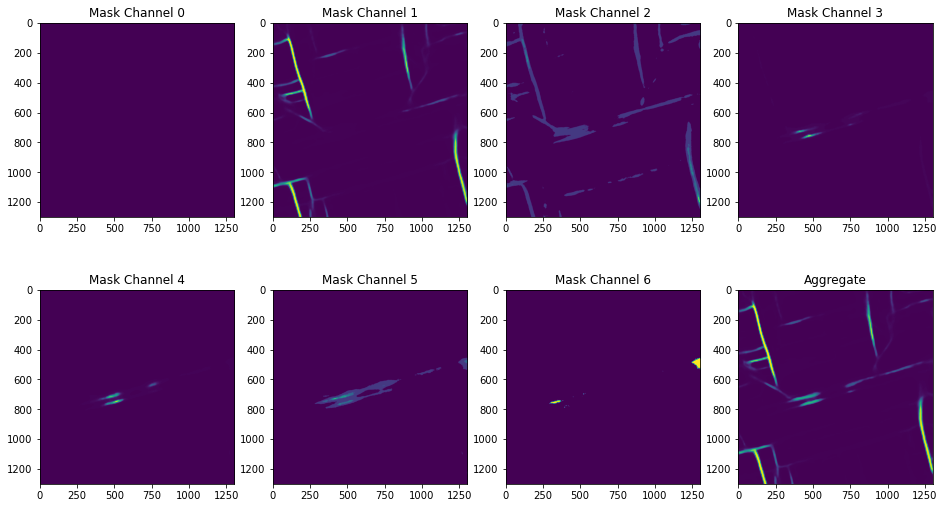

In [13]:
mask_pred_file = [z for z in os.listdir(mask_pred_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_pred_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

### Stitch slices back together

In [14]:
%run -i cresi/03_stitch.py { config_path }

Running stitch.py...
post_process_image - w, h: 5057 5057
0 / 16
Compute overlay count mask...
Compute normalized mask...
mask_norm.dtype: uint8
mask_raw.dtype: uint16
overlay_count.dtype: uint8
np.max(overlay_count): 4
np.min(overlay_count): 1
Saving to files...
mask_norm.shape: (8, 5057, 5057)
mask_norm.dtype: uint8
Time to run stitch.py and create large masks (and save): 4.778276443481445 seconds


mask_pred.shape: (8, 5057, 5057)


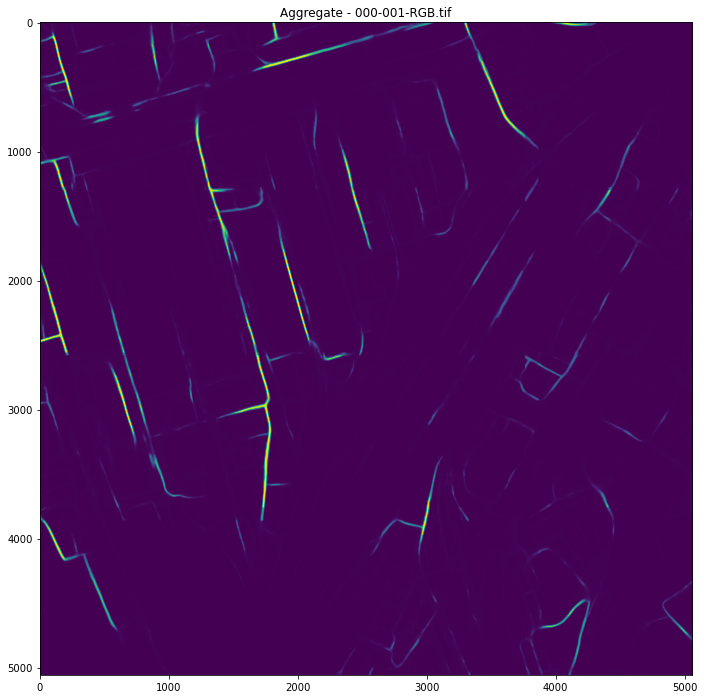

In [15]:
# Inspect the output
mask_pred_file = [z for z in os.listdir(mask_stitched_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_stitched_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

-----
The 04_skeletonize script creates a graph from the aggregate mask via a multi-step process:
    
1. Refine aggregate mask via smoothing, openings, and closings.

2. Extract a skeleton of the refined mask.

3. Build a graph from the skeleton.  

4. Clean out spurious edges and complete missing connections.

5. Output a csv of graph edges.  This csv output is included as a convenient intermediate step, since if speeds and geographic coordinates are not required we can forego Sections 5.4 and 5.5.

The 04_skeletonize.py script is multi-threaded to improve speed

In [16]:
%run -i cresi/04_skeletonize.py { config_path }

min_spur_length_pix: 30
im_dir: /opt/cresi/results/stitched/mask_norm
out_ske_dir: /opt/cresi/results/skeleton
out_gdir: /opt/cresi/results/sknw_gpickle
Running add_small_segments()
small_segs ['LINESTRING (4115.0 5009.0, 4110.0 5022.0)', 'LINESTRING (3754.0 2864.0, 3768.0 2872.0)', 'LINESTRING (4218.0 4477.0, 4235.0 4484.0)', 'LINESTRING (2088.0 2470.0, 2106.0 2480.0)', 'LINESTRING (2051.0 2166.0, 2059.0 2190.0)']
len df: 125
outfile: /opt/cresi/results/wkt_submission_nospeed.csv
Total time to run build_wkt_dir: 4.433260679244995 seconds


In [17]:
# inspect the output
csv_path = os.path.join(results_dir, 'wkt_submission_nospeed.csv')
df = pd.read_csv(csv_path)
df.head()

,ImageId,WKT_Pix
0,000-001-RGB,"LINESTRING (1805.0 2.0, 1818.0 54.0, 1829.0 12..."
1,000-001-RGB,"LINESTRING (3029.0 2.0, 2997.0 6.0, 2980.0 16...."
2,000-001-RGB,"LINESTRING (3292.0 2.0, 3325.0 95.0, 3356.0 15..."
3,000-001-RGB,"LINESTRING (3998.0 2.0, 4065.0 7.0, 4074.0 13...."
4,000-001-RGB,"LINESTRING (4236.0 2.0, 4226.0 11.0)"


-----
### 5.4. 05_wkt_to_G.py

This script reads the csv output by 04_skeletonize.py back into graph format (which is very quick), and then uses the metadata encoded in our geotiff test image to assign geographic coordinates to the graph.  Assigning geo-coordinates for thousands of nodes is a computationally intensive process, so this script is multi-threaded to improve performance. The script outputs a [NetworkX](https://networkx.github.io) graph structure in ~60 seconds.

In [18]:
%run -i cresi/05_wkt_to_G.py { config_path }

image_ids: ['000-001-RGB']
len image_ids: 1
000-001-RGB
im_file: /opt/cresi/data/raw_data/000-001-RGB.tif
Computing geo coords for nodes (12 threads)...
Updating data properties
params_tmp ('tmp', 2997.0, 6.0, '/opt/cresi/data/raw_data/000-001-RGB.tif')
tmp_dict: {'tmp': (23.930517461012105, 49.823720907985916)}
Computing geo coords for edges (12 threads)...
Updating edge data properties
0 10003 10048
0 10003 10048
0 10003 10048
0 10003 10048
Time to run wkt_to_G.py: 3.428158760070801 seconds


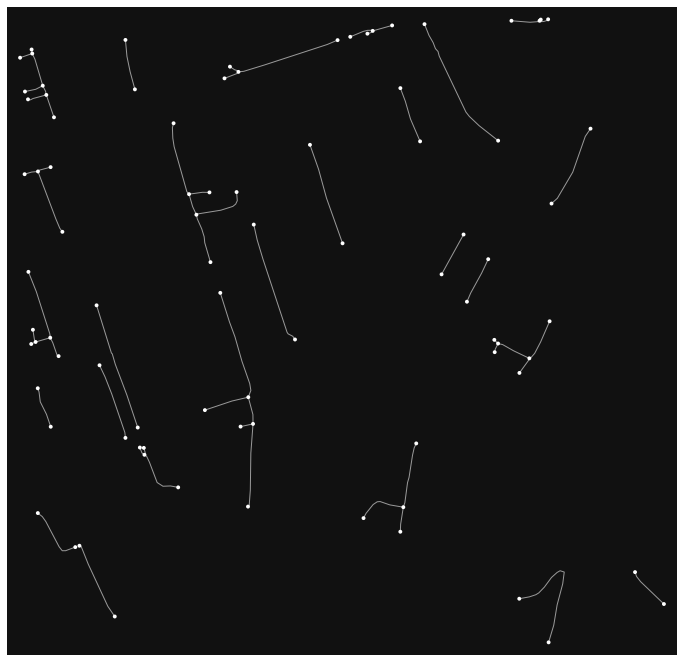

In [19]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, figsize=(12,12))